In [2]:
#pylab
%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

from PIL import Image
import trimesh, tetgen, pyvista as pv
from queue import PriorityQueue

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

# #load the libraries
from lib import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
#enter darkmode for jupyter notebooks
# !jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

#Hack for images to obey darkmode
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
#define Lamé parameters
mu = 1; lam = 1;
#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
calc_P = get_calc_P(mu, lam)
compute_nodal_elastic_forces= get_compute_nodal_elastic_forces(mu, lam)

# (don't) Opening Fenics or some ready-tech FE soln

In [4]:
# !pip install dolfinx

In [5]:
# from dolfin import *
# from ufl import Jacobian, diag
# from plotting import plot

# mesh = Mesh()
# filename = "shell.xdmf"
# f = XDMFFile(filename)
# f.read(mesh)

# def tangent(mesh):
#     t = Jacobian(mesh)
#     return as_vector([t[0,0], t[1, 0], t[2, 0]])/sqrt(inner(t,t))

# t = tangent(mesh)

- Option 1: inspect blender or fenics
- Option 2: make a toy case of tetrahedral stretching with a known response.

# Option 2: make a toy case of tetrahedral stretching with a known response.

In [7]:
# elements = element_array_index
# vertices = node_array_position

# N_elements = elements.shape[0]
# N_vertices = vertices.shape[0]

# momentum = node_array_momentum
# velocities = momentum.copy()
# for j in range(N_vertices):
#     velocities[j] /= node_array_mass[j]



In [8]:
X = np.array([[0, 0, 1], [0, 1, 0],
                  [-1, 0, 0], [+1, 0, 0]], dtype=float)
x = X.copy()
x[:,0] *= 2
elements = np.array([[0,1,2,3]])
K_index = 0
K_W = compute_element_volume(node_array_position=x, element_array_index=elements, K_index=K_index)
Ka = elements[K_index]
K_vertices = x[Ka]
Bm = compute_inverse_position(node_array_position=X, element_array_index=elements, K_index=K_index)
# Bm  = element_array_inverse_equilibrium_position[K_index]

print( (K_vertices, K_W, Bm, zero_mat.copy()) ) 

(array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [-2.,  0.,  0.],
       [ 2.,  0.,  0.]]), 0.6666666666666666, array([[-0. , -0. ,  1. ],
       [ 0. ,  1. ,  0. ],
       [-0.5, -0.5, -0.5]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))


In [9]:

# Bm  = element_array_inverse_equilibrium_position[K_index]
f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
f

array([[ 0.        ,  0.        , -0.46209812],
       [ 0.        , -0.46209812,  0.        ],
       [ 0.61552453,  0.23104906,  0.23104906],
       [-0.61552453,  0.23104906,  0.23104906]])

In [11]:
f[0]

array([ 0.        ,  0.        , -0.46209812])

In [12]:
f[3]

array([-0.61552453,  0.23104906,  0.23104906])

In [14]:
# D_K = compute_D_mat(node_array_position, element_array_index, K_index)
# X_inverse = np.linalg.inv(D_K)

# Bm is not right in the trivial case!

In [15]:
# X = np.array([[0, 0, 1], [0, 1, 0],
#                   [-1, 0, 0], [+1, 0, 0]], dtype=float)
X = np.array([[0, 1, 1], [0, 1, -1],
                  [-1, 0, 0], [+1, 0, 0]], dtype=float)
x = X.copy()
x[:,0] *= 2
elements = np.array([[0,1,2,3]])
K_index = 0
K_W = compute_element_volume(node_array_position=x, element_array_index=elements, K_index=K_index)
Ka = elements[K_index]

Bm = compute_inverse_position(node_array_position=X, element_array_index=elements, K_index=K_index)
# Bm  = element_array_inverse_equilibrium_position[K_index]
K_vertices = x[Ka]
x

array([[ 0.,  1.,  1.],
       [ 0.,  1., -1.],
       [-2.,  0.,  0.],
       [ 2.,  0.,  0.]])

In [16]:
Dm = get_D_mat(X[Ka])
Bm = np.linalg.inv(Dm)
Ds = get_D_mat(x[Ka])
# 	X_inverse = np.linalg.inv(D_K)

In [17]:
F = Ds @ Bm
# P = calc_P(F)
FT = np.linalg.inv(F.T)
J = np.linalg.det(F)
P = mu * (F - mu * FT) + lam * np.log(J) * FT

In [18]:
Dm

array([[-1., -1., -2.],
       [ 1.,  1.,  0.],
       [ 1., -1.,  0.]])

In [19]:

# K_vertices = X[Ka]
# x1  = K_vertices[0,0];y1 = K_vertices[0,1];z1 = K_vertices[0,2]
# x2  = K_vertices[1,0];y2 = K_vertices[1,1];z2 = K_vertices[1,2]
# x3  = K_vertices[2,0];y3 = K_vertices[2,1];z3 = K_vertices[2,2]
# x4  = K_vertices[3,0];y4 = K_vertices[3,1];z4 = K_vertices[3,2]
# D = np.array([
#       [x1-x4,x2-x4,x3-x4],
#       [y1-y4,y2-y4,y3-y4],
#       [z1-z4,z2-z4,z3-z4]])
# D

In [20]:
print(F)
print(P)

[[2. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.84657359 0.         0.        ]
 [0.         0.69314718 0.        ]
 [0.         0.         0.69314718]]


In [21]:
H = -K_W * P @ Bm
H

array([[ 0.        , -1.23104906, -1.23104906],
       [ 0.        , -0.46209812,  0.46209812],
       [ 0.46209812,  0.46209812,  0.        ]])

In [22]:
H[0]

array([ 0.        , -1.23104906, -1.23104906])

In [23]:
H = -K_W * P @ Bm.T
H = H.T

print('does f[2] = -f[3] in the x direction?')
f = zero_mat.copy()
f[0] += H[0]
f[1] += H[1]
f[2] += H[2]
f[3] += (-H[0] -H[1] -H[2])

# f[0] = H[0]
# f[1] = H[1]
# f[2] = H[2]
# f[3] = (-H[0] -H[1] -H[2])

f

does f[2] = -f[3] in the x direction?


array([[ 0.        , -0.46209812, -0.46209812],
       [ 0.        , -0.46209812,  0.46209812],
       [ 1.23104906,  0.46209812,  0.        ],
       [-1.23104906,  0.46209812,  0.        ]])

In [24]:
H.T

array([[ 0.        ,  0.        ,  1.23104906],
       [-0.46209812, -0.46209812,  0.46209812],
       [-0.46209812,  0.46209812,  0.        ]])

In [25]:
X

array([[ 0.,  1.,  1.],
       [ 0.,  1., -1.],
       [-1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [26]:
#from careful case
compute_element_volume(node_array_position=x, element_array_index=elements, K_index=K_index)

1.333333333333333

In [27]:
#from careful case
print( (K_vertices, K_W, Bm, zero_mat.copy(), f ) )  

(array([[ 0.,  1.,  1.],
       [ 0.,  1., -1.],
       [-2.,  0.,  0.],
       [ 2.,  0.,  0.]]), 1.333333333333333, array([[-0. ,  0.5,  0.5],
       [-0. ,  0.5, -0.5],
       [-0.5, -0.5, -0. ]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[ 0.        , -0.46209812, -0.46209812],
       [ 0.        , -0.46209812,  0.46209812],
       [ 1.23104906,  0.46209812,  0.        ],
       [-1.23104906,  0.46209812,  0.        ]]))


In [28]:
#from current case 
print( (K_vertices, K_W, Bm, zero_mat.copy(), f ) )  

(array([[ 0.,  1.,  1.],
       [ 0.,  1., -1.],
       [-2.,  0.,  0.],
       [ 2.,  0.,  0.]]), 1.333333333333333, array([[-0. ,  0.5,  0.5],
       [-0. ,  0.5, -0.5],
       [-0.5, -0.5, -0. ]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[ 0.        , -0.46209812, -0.46209812],
       [ 0.        , -0.46209812,  0.46209812],
       [ 1.23104906,  0.46209812,  0.        ],
       [-1.23104906,  0.46209812,  0.        ]]))


In [29]:
#from current case 


# dev rayleigh damping


In [44]:
comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)
velocities = 0.1*x

In [32]:
# def get_comp_nodal_damping_forces(mu, lam):
# 	calc_P = get_calc_P(mu, lam)

# 	def comp_nodal_elastic_forces(K_W, Bm, Ds, f_out):
# 		F = Ds @ Bm
# 		P = calc_P(F)
# 		H = -K_W * P @ Bm.T
# 		H = H.T
# 		f_out[0] += H[0]
# 		f_out[1] += H[1]
# 		f_out[2] += H[2]
# 		f_out[3] += (-H[0] -H[1] -H[2])
# 		return f_out
# 	return comp_nodal_elastic_forces
Bm  = element_array_inverse_equilibrium_position[K_index]

NameError: name 'element_array_inverse_equilibrium_position' is not defined

In [46]:
gamma = 1.
K_index = 0
Ka = elements[K_index]
K_vertices = x[Ka]
K_velocities = velocities[Ka]
Ds  = get_D_mat(K_vertices)
# Bm  = element_array_inverse_equilibrium_position[K_index]
Bm = compute_inverse_position(node_array_position=X, element_array_index=elements, K_index=K_index)
K_W = get_element_volume(Ds)

# delta_Ds = 
delta_f = zero_mat.copy()

In [50]:
compute_nodal_elastic_force_differentials = get_compute_nodal_elastic_force_differentials(mu, lam)

In [51]:
compute_nodal_elastic_force_differentials

<function lib.model.elastic.get_compute_nodal_elastic_force_differentials.<locals>.compute_nodal_elastic_force_differentials(delta_K_vertices, K_vertices, K_W, Bm, delta_f)>

In [ ]:
compute_nodal_elastic_force_differentials(delta_K_vertices=-K_velocities, K_vertices, K_W, Bm, delta_f)


In [97]:
def get_compute_nodal_elastic_force_differentials(mu,lam):
    calc_delta_P = get_calc_delta_P(mu, lam)
    def compute_nodal_elastic_force_differentials(delta_Ds, Ds, K_W, Bm, delta_f):
        delta_F = delta_Ds @ Bm
        F = Ds @ Bm
        delta_P = calc_delta_P(delta_F, F)
        delta_H = -K_W * delta_P @ Bm.T
        delta_H = delta_H.T
        delta_f[0] = delta_H[0]
        delta_f[1] = delta_H[1]
        delta_f[2] = delta_H[2]
        delta_f[3] = -(delta_H[0] + delta_H[1] + delta_H[2])
        return delta_f
    return compute_nodal_elastic_force_differentials

def get_compute_nodal_damping_forces(mu,lam,gamma):
    compute_nodal_elastic_force_differentials = get_compute_nodal_elastic_force_differentials(mu,lam)
    def compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm,delta_f):
        delta_Ds = get_D_mat(-K_velocities)
        f_damping = -gamma * compute_nodal_elastic_force_differentials(delta_Ds, Ds, K_W, Bm, delta_f)
        return f_damping
    return compute_nodal_damping_forces

In [101]:
f_damping = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())
f_damping

array([[-0.        , -0.28712352, -0.28712352],
       [-0.        , -0.28712352,  0.28712352],
       [ 0.24356176,  0.28712352, -0.        ],
       [-0.24356176,  0.28712352, -0.        ]])

__I checked that damping forces point in the opposite direction of the input velocity.__

# DONE: get a mechanical energy measure of a single element

In [104]:
eye = np.eye(3)

In [109]:
# #define the isotropic invariants
# FTF = F.T @ F
# I1 = np.trace(FTF)
# I2 = np.trace(FTF @ FTF)
# # I3 = np.linalg.det(FTF) #= np.linalg.det(F) ** 2 = J **2
# I3 = J ** 2

In [116]:
node_array_mass = np.array([1.,1.,1.,1.,])
# K_masses     = node_array_mass[Ka]

In [132]:
#DONE: precompute mass_of_K
mass_density = 1.
# mass_of_K = K_W * mass_density



In [126]:
#neohookean elastic energy of element
J  = np.linalg.det(F)
I1 = np.trace(F.T @ F)
energy_density = mu / 2 * (I1 - 3) - mu * np.log(J) + lam / 2 * np.log(J) ** 2 
elastic_energy = K_W * energy_density

In [133]:
#kinetic energy of element
Na = 4
kinetic_energy = 0.
for a in range(Na):
    kinetic_energy += ( mass_of_K / Na ) * np.dot(K_velocities[a],K_velocities[a])
kinetic_energy /= 2

In [134]:
K_energy = kinetic_energy + elastic_energy

In [138]:
mass_of_K

1.333333333333333

In [140]:
# def comp_elastic_energy (  mass_of_K, K_W, Bm, Ds, mu, lam ):
#     '''elastic potential energy of element'''
#     F = Ds @ Bm
#     J  = np.linalg.det(F)
#     I1 = np.trace(F.T @ F)
#     energy_density = mu / 2 * (I1 - 3) - mu * np.log(J) + lam / 2 * np.log(J) ** 2 
#     elastic_energy = K_W * energy_density
#     return elastic_energy

# def comp_kinetic_energy ( mass_of_K, K_velocities):
#     '''kinetic energy of element'''
#     Na = 4
#     kinetic_energy = 0.
#     for a in range(Na):
#         kinetic_energy += ( mass_of_K / Na ) * np.dot(K_velocities[a],K_velocities[a])
#     kinetic_energy /= 2
#     return kinetic_energy

# def comp_element_energy ( mass_of_K, K_velocities, K_W, Bm, Ds, mu, lam):
#     return comp_kinetic_energy ( mass_of_K, K_velocities) + comp_elastic_energy (  mass_of_K, K_W, Bm, Ds, mu, lam )

In [145]:
# mass_of_K = element_array_mass[K_index]


# TODO: make time step size measures 

In [3]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

#define Lamé parameters
mu = 1.; lam = 1.; 
#define coefficient for Rayleigh damping
gamma = 1.;

#define adaptive time stepping absolute tolerances
atol_x = 1e-4; atol_v = 1e-4; 
btol_x = 1e-12; btol_v = 1e-12; 

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

#initialize stepsizes
stepsize_init = 0.001
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
#perturb momentum in the outward x direction and let it run overnight with a small timestep
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]
v_scale = 1
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [6]:
#basic steapsize measures
stepsize_mean = np.mean(element_array_stepsize)
stepsize_std = np.std(element_array_stepsize)
stepsize_median = np.median(element_array_stepsize)

#TODO: pass element_array_count_calls_one_step to the integrate_system_... function and keep track of how many times each element is called to time step
#TODO: keep track of how many times each element config is updated with element_array_count_config_updates


In [15]:
# from IPython.utils import io

# def get_img_of_system(vertices, input_file_name):
#     with io.capture_output() as captured:
#         img = plot_mesh(vertices, input_file_name=input_file_name);
#     return img

In [12]:
from lib.viewer.vtk_viewer_of_mesh import *

img = plot_mesh(vertices, input_file_name=input_file_name, darkmode=False)

In [ ]:
img = get_img_of_system(vertices, input_file_name, darkmode = False)

# TODO: calibrate neural step times with some loss scale 
(squared or linear)?  does it matter!?

In [3]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .0#1.#1.;
#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5#0.5
v_scale = 2.
mass_density=1.
stepsize_init = 0.0001#0.00001  #0.0001
atol_x = 1e-08#0.0001#0.001#1e-7; 
atol_v = 1e-08#0.0001#0.001#1e-7; 
btol_x = 1e-09#0.00001#0.001#1e-10; 
btol_v = 1e-09#0.00001#0.001#1e-10; 
input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'#path to mesh
data_folder =  os.path.join(nb_dir,'../data/mov_csv')#where to save results


data_fn = f"dormand_prince_asynch_fixed_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
TEXTfoo = lambda N_vertices,N_elements: f"""
TEXT=$'an inward squish
        Asynchronous Variational Integrator 
        Dormand–Prince Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""

# data_fn = f"avi_esynchronous_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"dormand_prince_synch_fixed_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
TEXT = TEXTfoo(N_vertices,N_elements)
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
# TEXT = f"""
# TEXT=$'an inward squish
#         Synchronous Variational Integrator 
#         Explicit Newmark Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [4]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [3.05175781e-09 6.10351563e-09 1.22070313e-08 2.44140625e-08
 4.88281250e-08 9.76562500e-08 1.95312500e-07 3.90625000e-07
 7.81250000e-07 1.56250000e-06 3.12500000e-06 6.25000000e-06
 1.25000000e-05 2.50000000e-05 5.00000000e-05 1.00000000e-04
 2.00000000e-04 4.00000000e-04 8.00000000e-04 1.60000000e-03
 3.20000000e-03 6.40000000e-03 1.28000000e-02 2.56000000e-02
 5.12000000e-02 1.02400000e-01 2.04800000e-01 4.09600000e-01
 8.19200000e-01 1.63840000e+00]


In [6]:
# get_compute_next_stepsize_neural_learning_rate
one_step_explicit_dormand_prince_method=get_one_step_explicit_dormand_prince_method(mu, lam, gamma)

In [72]:
h = 0.001
K_index = 700#7
Bm = element_array_inverse_equilibrium_position[K_index]
Ka = element_array_index[K_index]
x = vertices[Ka].copy()
v = velocities[Ka].copy()
tau_of_K = tauK[K_index]
K_tau = tau[Ka].copy()
K_masses = element_array_mass[Ka]
Ds = get_D_mat(x)
W = get_element_volume(Ds)
mass_of_K  = element_array_mass[K_index]


In [85]:
#loss =  (1.-lasso_fraction) * (Delta_energy/scale_for_Delta_energy)**2 + lasso_fraction * np.abs(Delta_energy/scale_for_Delta_energy)
def comp_loss_given_h(h):
    max_err, mav_err, x_out,v_out,x_err,v_err =  one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm,)

    #compute energy of configuration
    Ds = get_D_mat(x_out)
    W = get_element_volume(Ds)
    energy_d = comp_element_energy ( mass_of_K, v_out, W, Bm, Ds, mu, lam)

    #compute energy of configuration
    Ds = get_D_mat(x_err)
    W = get_element_volume(Ds)
    energy_e = comp_element_energy ( mass_of_K, v_err, W, Bm, Ds, mu, lam)

    Delta_energy = energy_d-energy_e
    # 0.00023493635278172754

    loss_scale = 1e-04
    scale_for_Delta_energy = 8e-04#2e-04
    Delta_energy /= scale_for_Delta_energy
    
    loss = (1.-lasso_fraction) * Delta_energy**2 + lasso_fraction * np.abs(Delta_energy)
    return Delta_energy#loss#

In [86]:
#ASSERT ^this is of order unity

In [87]:
#TODO: test for dependence of loss scale on time step size
loss_lst = []
# h_array = np.logspace(-10,-5)
h_array = np.logspace(-5,-2)
# h_array = np.logspace(-2,-1)
# h_array = np.logspace(-1,0)
for h in h_array:
    loss = comp_loss_given_h(h)
    loss_lst.append(loss)
    

In [88]:
x_values = h_array
y_values = np.array(loss_lst)

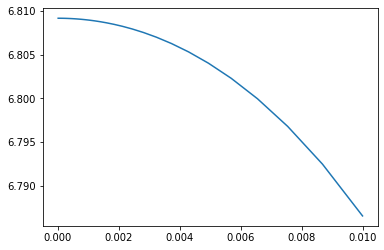

In [89]:
plt.plot(x_values,y_values)

__Result:__ this loss function is not monotonically increasing for some elements but monotonically decreasing for others, therefore we cannot assume decreasing stepsize will reduce energy error/loss.

- IF the current "neural time steps" was tested, it would exhibit instabilities.  A more sophisticated method involving gradient descent and/or dE/dt  will be necessary.

In [ ]:
# still, i'll make a movie cause I already set it up...